This RNN attempts to predict a time series shifted one unit into the future

In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(start=xmin,stop=xmax,num=num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series): #'return true'; convenience method
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False): #ts = time series
        #grab random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        #convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution)) #converts random start to be somewhere on our time series
        
        #create batch time series on x-axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        #create y data for the time series x-axis from previous step
        y_batch = np.sin(batch_ts)
        
        #formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1) #original ts,
                                                                                        #ts shifted over by 1
        
        

In [6]:
ts_data = TimeSeriesData(250,0,10) #250 points between 0 and 10

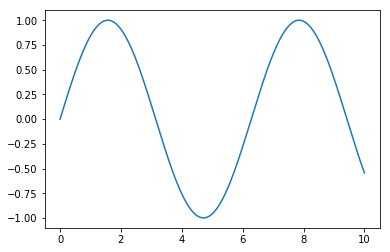

In [7]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [8]:
num_time_steps = 30

In [9]:
y1,y2,ts = ts_data.next_batch(batch_size=1,steps=num_time_steps,return_batch_ts=True)

In [10]:
ts

array([[ 8.52285077,  8.56285077,  8.60285077,  8.64285077,  8.68285077,
         8.72285077,  8.76285077,  8.80285077,  8.84285077,  8.88285077,
         8.92285077,  8.96285077,  9.00285077,  9.04285077,  9.08285077,
         9.12285077,  9.16285077,  9.20285077,  9.24285077,  9.28285077,
         9.32285077,  9.36285077,  9.40285077,  9.44285077,  9.48285077,
         9.52285077,  9.56285077,  9.60285077,  9.64285077,  9.68285077,
         9.72285077]])

In [11]:
ts.shape

(1, 31)

In [12]:
ts.flatten() #can't have dimensions if you want to plot the data -> flatten it

array([ 8.52285077,  8.56285077,  8.60285077,  8.64285077,  8.68285077,
        8.72285077,  8.76285077,  8.80285077,  8.84285077,  8.88285077,
        8.92285077,  8.96285077,  9.00285077,  9.04285077,  9.08285077,
        9.12285077,  9.16285077,  9.20285077,  9.24285077,  9.28285077,
        9.32285077,  9.36285077,  9.40285077,  9.44285077,  9.48285077,
        9.52285077,  9.56285077,  9.60285077,  9.64285077,  9.68285077,
        9.72285077])

In [13]:
ts.flatten().shape

(31,)

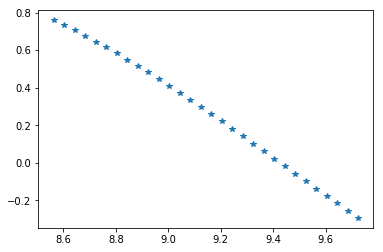

In [14]:
plt.plot(ts.flatten()[1:],y2.flatten(),'*') #have to reduce number of points in ts to match y2

In the graph above, different sections of the sinusoidal wave may be shown each time the command is executed.

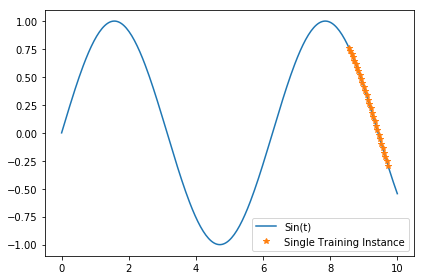

In [15]:
plt.plot(ts_data.x_data,ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout() #moves the legend so it doesn't block the plotted line

Training Data

In [16]:
train_inst = np.linspace(start=5,stop=5 + ts_data.resolution*(num_time_steps+1),num=num_time_steps+1)

In [17]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

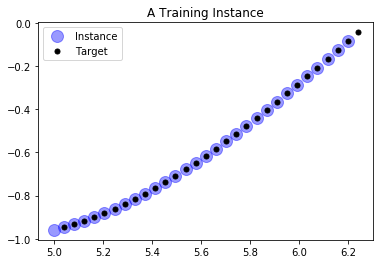

In [18]:
plt.title('A Training Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=12,alpha=0.4,label='Instance') #'bo' are blue dots

#now we've plotted this training data, let's plot the prediction shifted one time step over
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize=5,label='Target')

plt.legend()

# Creating the model

In [19]:
tf.reset_default_graph()

In [20]:
num_inputs = 1 #we only have one feature in this model-- given an x-value, predict y-value

In [21]:
num_neurons = 100 #neurons per layer

In [22]:
num_outputs = 1

In [23]:
learning_rate = 0.001 # use 0.0001 for BasicRNNCell

In [24]:
num_train_iterations = 2000 #number of steps

In [25]:
batch_size = 1

### Placeholders

In [26]:
x = tf.placeholder(tf.float32,shape=[None,num_time_steps,num_inputs])

In [27]:
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

### RNN cell layer

In [28]:
#cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu)
cell = tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=num_outputs) #need so num outputs = 1, not 100

In [29]:
outputs, states = tf.nn.dynamic_rnn(cell,x,dtype=tf.float32)

In [30]:
# MSE (Mean Squared Error)
loss = tf.reduce_mean(tf.square(outputs-y))

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [32]:
train = optimizer.minimize(loss)

In [33]:
init = tf.global_variables_initializer()

### Session

In [34]:
saver = tf.train.Saver() #saves and stores variables

In [35]:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iterations):
        x_batch,y_batch = ts_data.next_batch(batch_size=batch_size,steps=num_time_steps)
        sess.run(train,feed_dict={x:x_batch,y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={x:x_batch,y:y_batch}) #mean squared error
            print(iteration,'\t MSE',mse)
            
    saver.save(sess,'./my_rnn_time_series_model_codealong') #saves the model in that location

0 	 MSE 0.599699
100 	 MSE 0.0432589
200 	 MSE 0.0053599
300 	 MSE 0.000328089
400 	 MSE 0.00669341
500 	 MSE 0.010968
600 	 MSE 0.000614729
700 	 MSE 0.00447831
800 	 MSE 0.000691167
900 	 MSE 0.00253535
1000 	 MSE 0.000849463
1100 	 MSE 0.000215292
1200 	 MSE 0.00231711
1300 	 MSE 0.000141723
1400 	 MSE 8.59505e-05
1500 	 MSE 2.60342e-05
1600 	 MSE 9.62897e-05
1700 	 MSE 1.89872e-05
1800 	 MSE 0.000136807
1900 	 MSE 0.000213259


In [36]:
with tf.Session() as sess:
    saver.restore(sess,'./my_rnn_time_series_model_codealong')
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict={x:x_new})

INFO:tensorflow:Restoring parameters from ./my_rnn_time_series_model_codealong


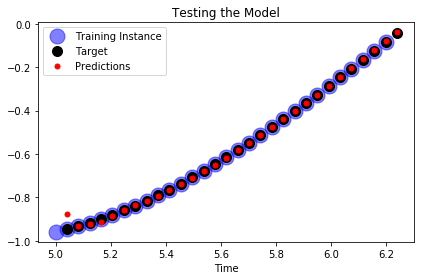

In [37]:
plt.title('Testing the Model')

#Training Intance
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label='Training Instance')

#Target to Predict (correct test values of np.sin(train))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize=10,label='Target')

#Models Prediction
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize=10,label='Predictions')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

### Generating a New Sequence

In [38]:
with tf.Session() as sess:
    saver.restore(sess,'./my_rnn_time_series_model_codealong')
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={x:x_batch})
        zero_seq_seed.append(y_pred[0,-1,0]) #in the end, should have num_time_steps 0's then predicted values

INFO:tensorflow:Restoring parameters from ./my_rnn_time_series_model_codealong


Text(0,0.5,'Y')

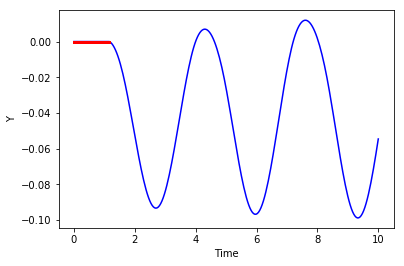

In [39]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-') #plots entire time series
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth=3) #shows first value
plt.xlabel('Time')
plt.ylabel('Y')

In [40]:
with tf.Session() as sess:
    saver.restore(sess,'./my_rnn_time_series_model_codealong')
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={x:x_batch})
        training_instance.append(y_pred[0,-1,0]) #in the end, should have num_time_steps 0's then predicted values

INFO:tensorflow:Restoring parameters from ./my_rnn_time_series_model_codealong


Text(0,0.5,'Y')

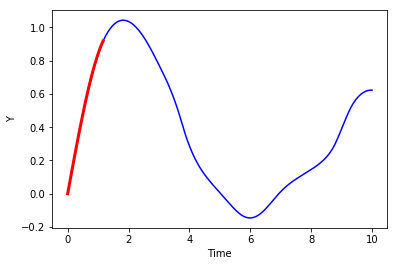

In [41]:
plt.plot(ts_data.x_data,training_instance,'b-') #plots entire time series
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps],'r',linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')